In [1]:
import sys
import shap 
import pickle
import sklearn 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 

In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results







In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:
configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'dd_demo-mlp_cls--shuffled:True--exclude at risk:0'

# demo-Fcls-mm:

- Chosen model: **MLP**


https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/




## Load Data

In [8]:

dd = DyslexiaData(path="../../datasets/", n_repeats=5)




In [9]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 


In [10]:

df_data_to_use.head()



,Group,SubjectID,Sex,Grade,Age,IQ,Reading_speed
0,1,10,1,4,10,23,102.0
1,1,108,1,4,10,34,139.0
2,1,11,2,4,10,34,110.0
3,1,11_norm1,1,2,9,28,71.0
4,1,12_norm1,2,2,8,32,60.0


In [11]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [12]:

x_org.head()



,Age,Grade_4,Sex_2,IQ,Grade_3,Grade_6,Grade_5,Grade_1,Grade_2,Sex_1
0,10,1,0,23,0,0,0,0,0,1
1,10,1,0,34,0,0,0,0,0,1
2,10,1,1,34,0,0,0,0,0,0
3,9,0,0,28,0,0,0,0,1,1
4,8,0,1,32,0,0,0,0,1,0


In [13]:
# for i in range(x_org.Sex_1.values.shape[0]):
#     print(x_org.Sex_1.values[i], x_org.Sex_2.values[i])

In [14]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,139.0
2,1,110.0
3,1,71.0
4,1,60.0


In [15]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [16]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (307, 10)


In [17]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [18]:

data



defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.5  , 1.   , 0.   , ..., 0.   , 0.   , 1.   ],
                                 [0.5  , 1.   , 0.   , ..., 0.   , 0.   , 1.   ],
                                 [0.5  , 1.   , 1.   , ..., 0.   , 0.   , 0.   ],
                                 ...,
                                 [0.375, 0.   , 0.   , ..., 0.   , 0.   , 1.   ],
                                 [0.5  , 0.   , 0.   , ..., 0.   , 0.   , 1.   ],
                                 [0.5  , 0.   , 1.   , ..., 0.   , 0.   , 0.   ]]),
                          'x_test': array([[0.375, 0.   , 0.   , 0.619, 0.   , 0.   , 0.   , 0.   , 1.   ,
                                  1.   ],
                                 [0.25 , 0.   , 1.   , 0.905, 0.   , 0.   , 0.   , 0.   , 1.   ,
                                  0.   ],
                                 [0.125, 0.   , 0.   , 0.952, 0.   , 0.   , 0.   , 1.   , 0.   ,

## Load the tuned parameters

In [19]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'identity'),
             ('hidden_layer_sizes', 173),
             ('max_iter', 31270),
             ('solver', 'lbfgs')])

In [20]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl


MLPClassifier(activation='identity', hidden_layer_sizes=173, max_iter=31270,
              solver='lbfgs', verbose=1)

In [21]:
x_train = data["6"]["x_train"]
x_test = data["6"]["x_test"]
y_train = data["6"]["y_train"]
y_test = data["6"]["y_test"]



In [22]:

class_names = ['Norm', 'At-risk', 'Dyslexic']




In [23]:
# from joblib import dump, load


# mdl = load(configs.models_path.joinpath(configs.specifier+".joblib"))
# mdl


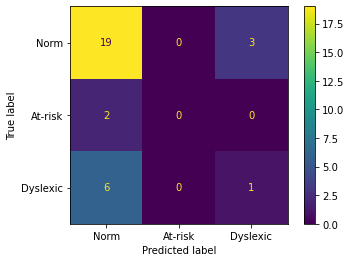

Kappa: -0.005899705014749346 AUC ROC: 0.5520099493264121


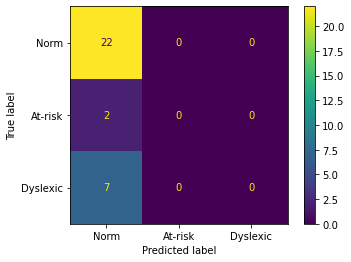

Kappa: 0.0 AUC ROC: 0.594495427017674


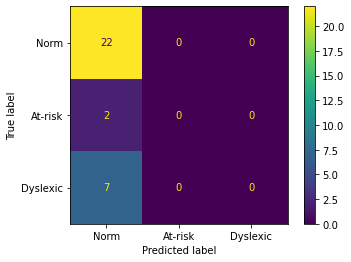

Kappa: 0.0 AUC ROC: 0.6313110245952293


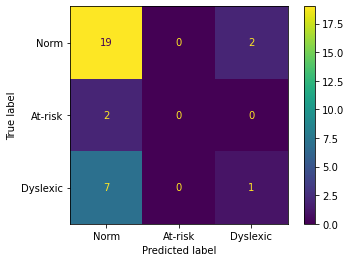

Kappa: 0.022922636103151817 AUC ROC: 0.5906393577404846


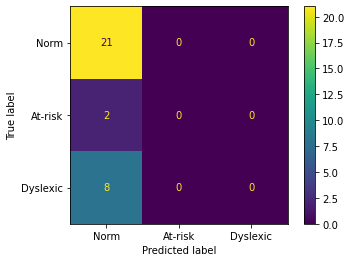

Kappa: 0.0 AUC ROC: 0.6566547371475553


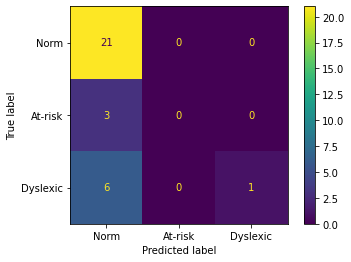

Kappa: 0.13888888888888884 AUC ROC: 0.6556259600614439


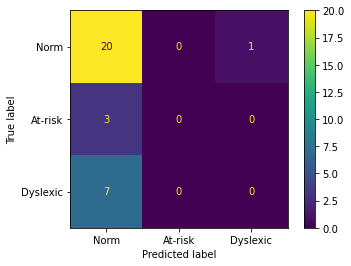

Kappa: -0.05246913580246915 AUC ROC: 0.6546274961597542


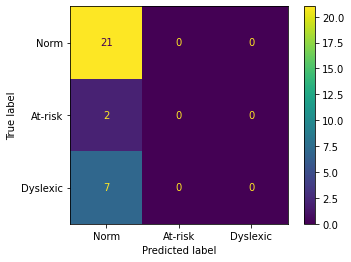

Kappa: 0.0 AUC ROC: 0.6546123763515067


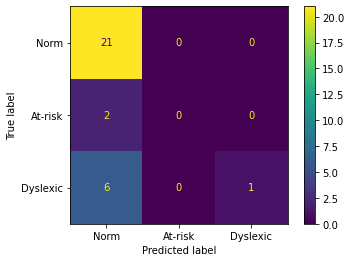

Kappa: 0.15492957746478864 AUC ROC: 0.677237175063262


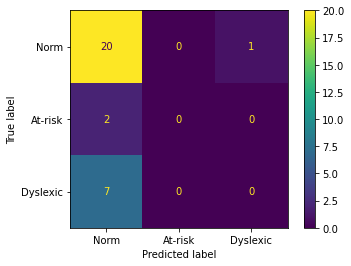

Kappa: -0.05633802816901423 AUC ROC: 0.42739245456636765


In [24]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )




for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [25]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.003 0.045 0.030 0.040 0.543 0.094 0.684 0.031 0.582 0.031 0.609 0.071 29.861 1.090 0.193 0.022 0.684 0.031


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined an

In [26]:


mdl.fit(x_train, y_train)




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2425     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39959D+00    |proj g|=  4.66567D-01

At iterate    1    f=  9.27038D-01    |proj g|=  2.02408D-01

At iterate    2    f=  7.75078D-01    |proj g|=  5.40691D-02

At iterate    3    f=  7.58372D-01    |proj g|=  3.62607D-02

At iterate    4    f=  7.49178D-01    |proj g|=  2.90058D-02

At iterate    5    f=  7.27361D-01    |proj g|=  1.66386D-02

At iterate    6    f=  7.18422D-01    |proj g|=  7.77452D-03

At iterate    7    f=  7.12829D-01    |proj g|=  4.52058D-03

At iterate    8    f=  7.08078D-01    |proj g|=  4.58152D-03

At iterate    9    f=  7.06286D-01    |proj g|=  3.05831D-03

At iterate   10    f=  7.05195D-01    |proj g|=  1.41851D-03

At iterate   11    f=  7.04570D-01    |proj g|=  1.75442D-03

At iterate   12    f=  7.03500D-01    |proj g|=  2.23182D-03

At iterate   13    f=  7.0

 This problem is unconstrained.


MLPClassifier(activation='identity', hidden_layer_sizes=173, max_iter=31270,
              solver='lbfgs', verbose=1)

In [27]:

print("model fitted")



model fitted


In [28]:
mdl.predict_proba(x_test[5:10:, :])




array([[0.574, 0.043, 0.382],
       [0.561, 0.042, 0.397],
       [0.745, 0.08 , 0.175],
       [0.654, 0.015, 0.331],
       [0.854, 0.146, 0.   ]])

In [29]:
mdl.predict(x_test[5:10:, :])



array([1, 1, 1, 1, 1])

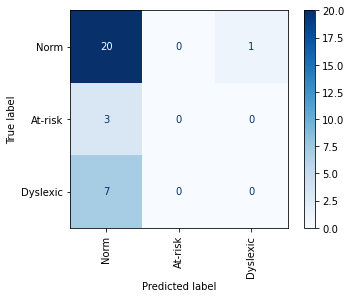

In [30]:


disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)






In [31]:

sklearn.metrics.roc_auc_score(y_test, 
                              mdl.predict_proba(x_test),
                              multi_class="ovr",
                              average="weighted")




0.5317588325652841

- 




In [32]:


len(list(x_org.columns)) == x_test.shape[1]




True

In [33]:
explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [34]:


shap_values = explainer(x_test)




In [35]:


print("Shap values are determined!")



Shap values are determined!


In [36]:


y_test.shape, x_test.shape, shap_values.values.shape



((31,), (31, 10), (31, 10))

### SHAP Summary Plots


Permutation importance numerically measures the importance of features. This simplifies the comparison between features.  However, the considered interaction between features during the features importance determination process, as can be considered a severe drawback of this method. SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 




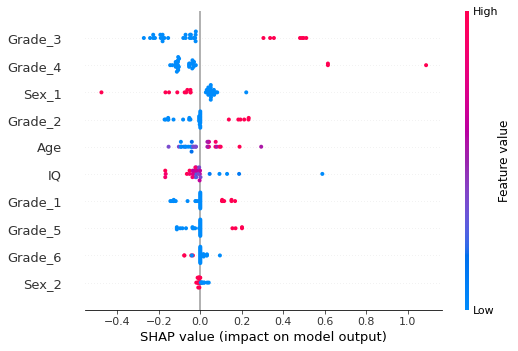

In [37]:
shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )



- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- 

In [ ]:
# shap.summary_plot(shap_values, 
#                   x_test, 
#                   plot_type="bar", 
#                   class_names=class_names, 
#                   feature_names=list(x_org.columns),
#                   alpha=0.1,
#                   color_bar=True,
#                   color_bar_label=True
#                  )



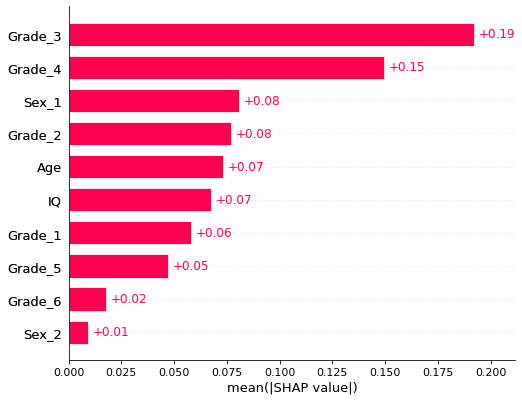

In [40]:

shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")



### Shap bar plot


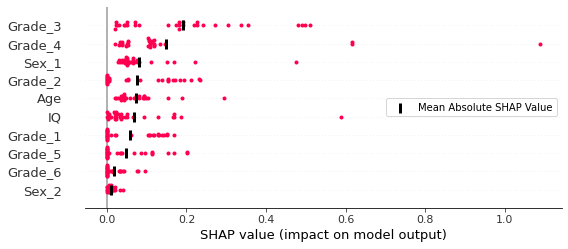

In [41]:
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")



##### Beeswarm-bar plot: 

- 

### SHAP Dependence Contribution Plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.


- Each dot is a single prediction (row) from the dataset.
- The x-axis is the actual value from the dataset.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.

FixedFormatter should only be used together with FixedLocator


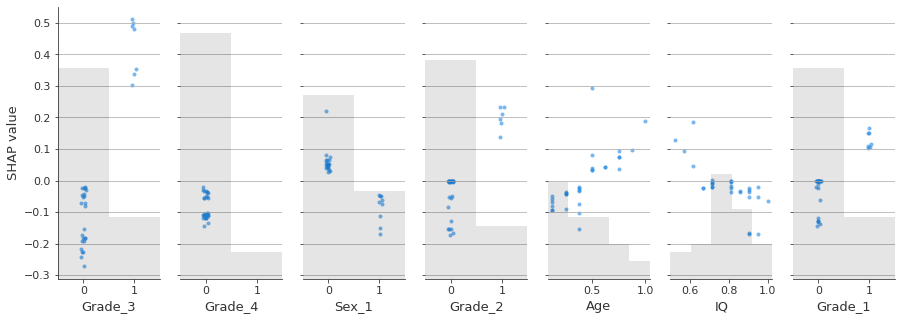

In [42]:
n = 7
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")

In [ ]:
# n = 5
# fig, ax = plt.subplots(1, n, figsize=(15, 5))

# for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
#     if i < n:
#         shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
#         ax[i].grid(axis="y")
#         if i != 0:
#             ax[i].set_ylabel("")
#             ax[i].spines["left"].set_visible(False)
#             ax[i].set_ylim(ax[0].get_ylim())
#             ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
#         else:
#             ax[i].set_ylabel("SHAP value")
# # fig.savefig("plots/scatter_top5.png")

##### Dependece plots:

- 


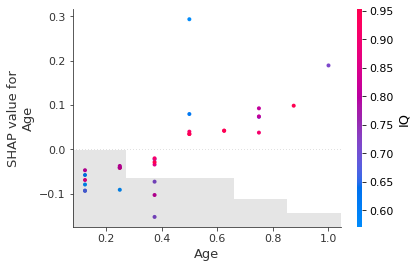

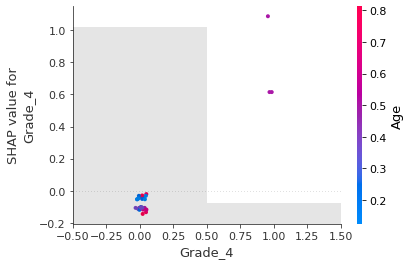

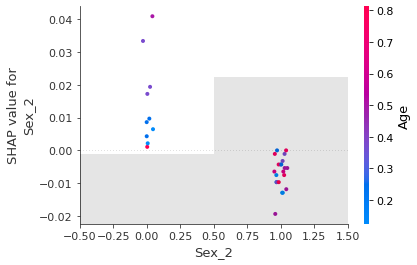

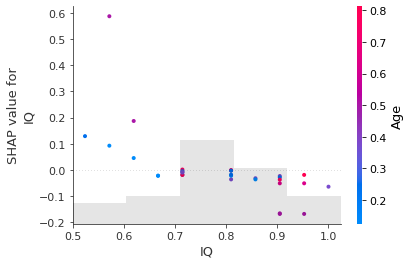

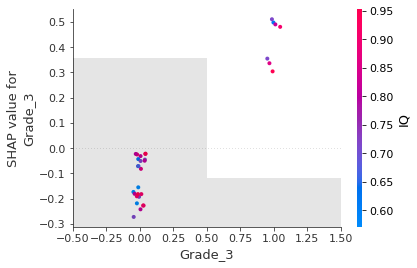

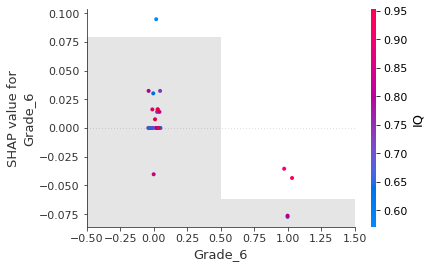

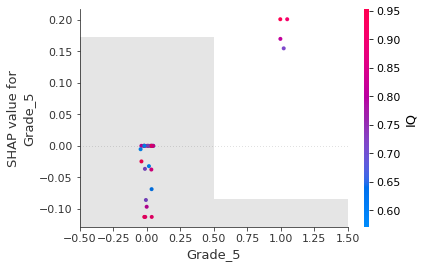

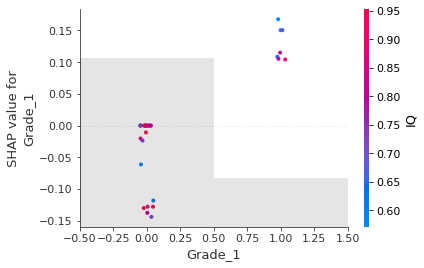

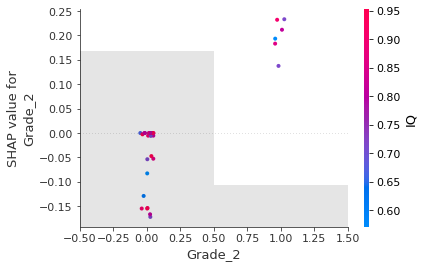

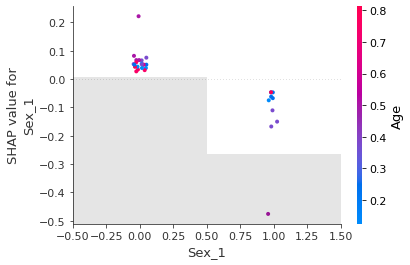

In [43]:
for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)



- 


## Individual force plots of 3 randomly selected samples of each class


In [63]:



normals = np.where(y_test == 1)[0]
at_risks = np.where(y_test == 2)[0]
dyslexics = np.where(y_test == 3)[0]



n_size = 5
np.random.seed(123)
normals_rnd = np.random.choice(normals, n_size)
at_risks_rnd = np.random.choice(at_risks, n_size)
dyslexics_rnd = np.random.choice(dyslexics, n_size)




In [64]:
normals_rnd



array([19,  2,  2,  8, 27])

In [65]:
at_risks_rnd


array([23, 20, 23, 20,  9])

In [66]:

dyslexics_rnd


array([ 6, 25,  6,  5, 25])

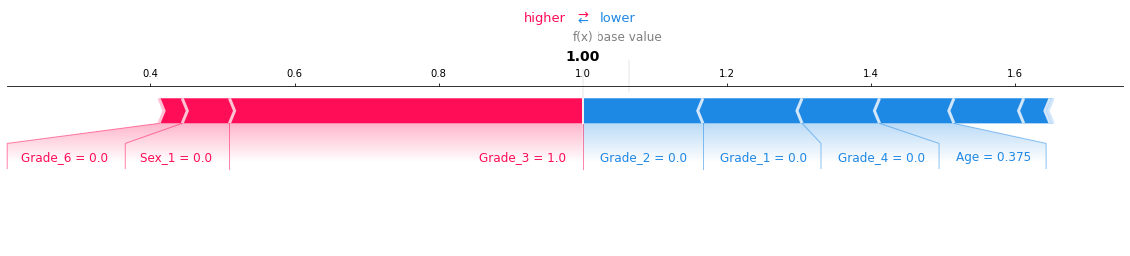

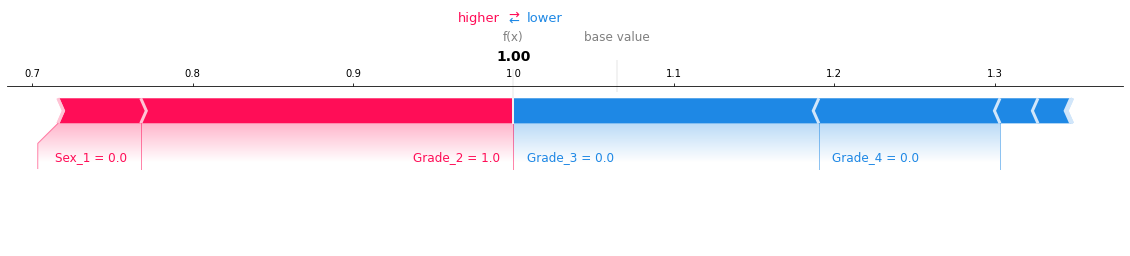

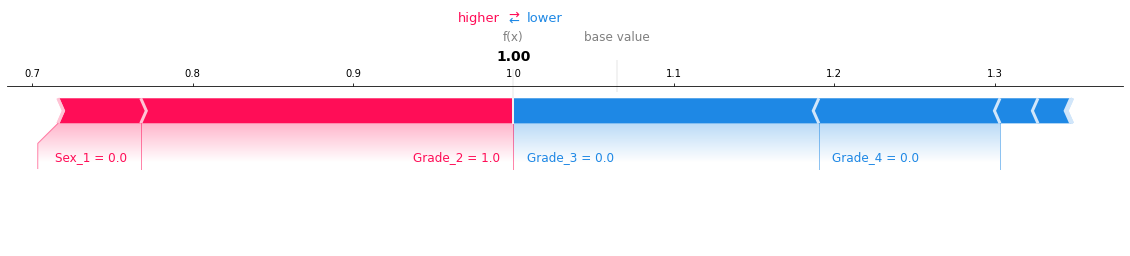

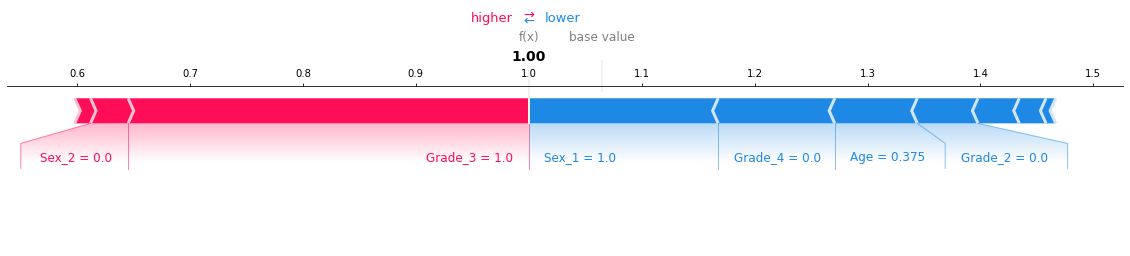

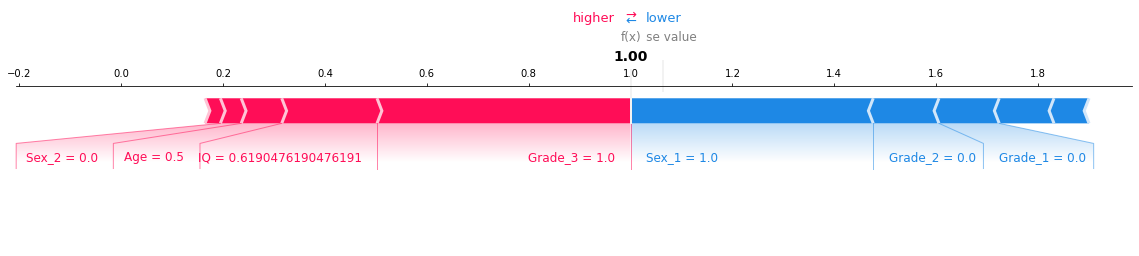

In [67]:
for n in normals_rnd:
    shap.plots.force(shap_values[n], show=False, matplotlib=True)
    
    

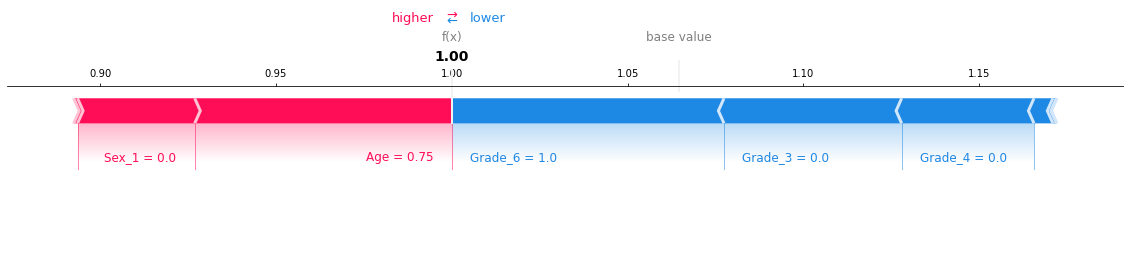

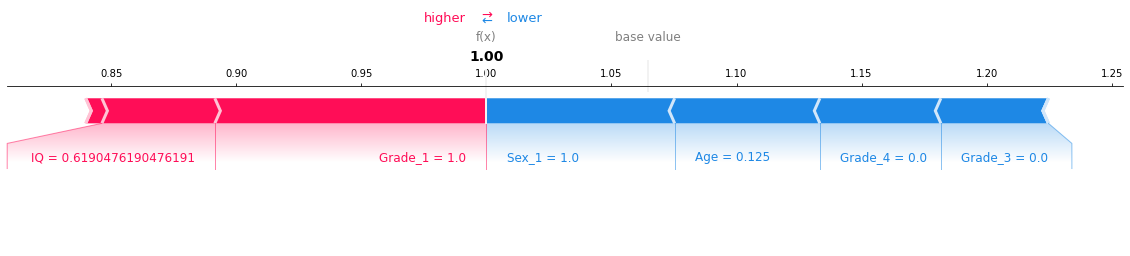

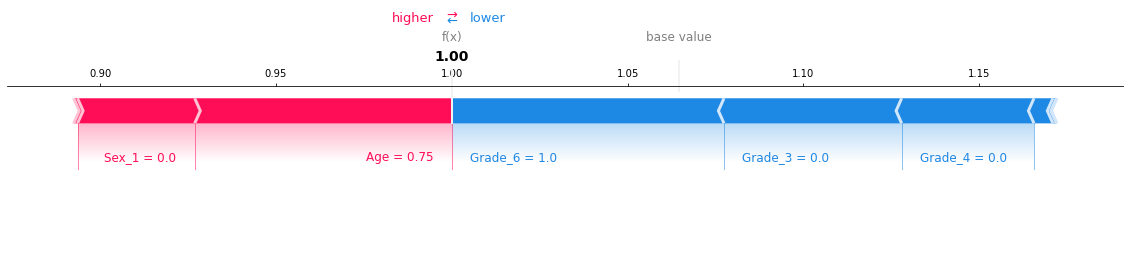

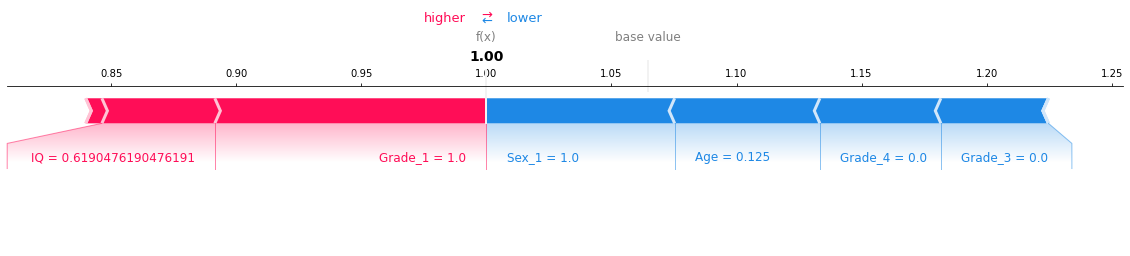

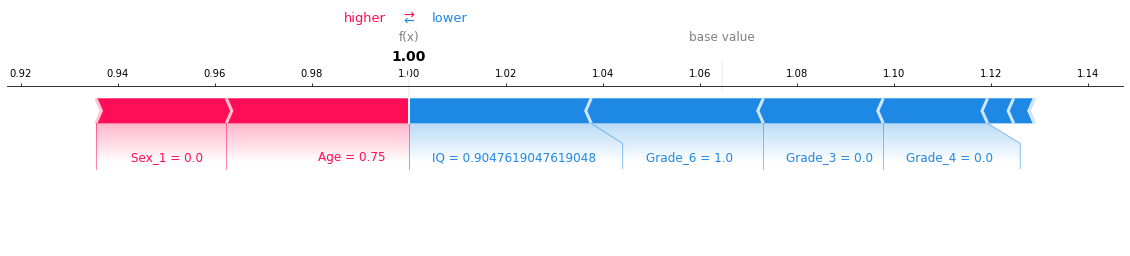

In [68]:
for r in at_risks_rnd:
    shap.plots.force(shap_values[r], show=False, matplotlib=True)
    
    

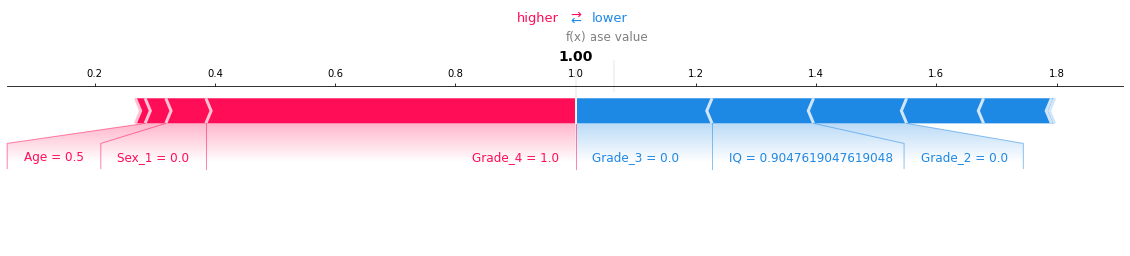

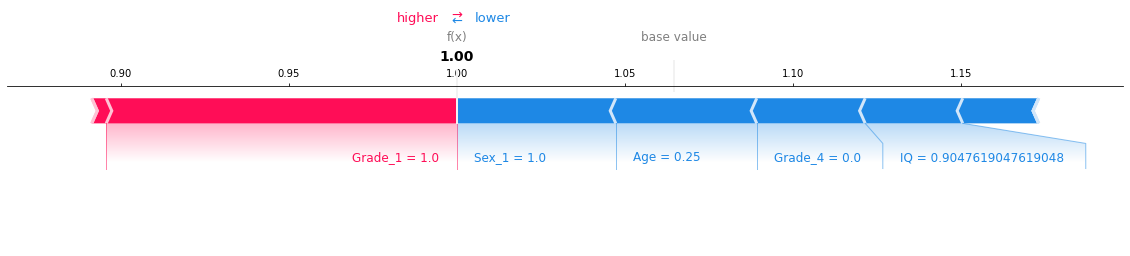

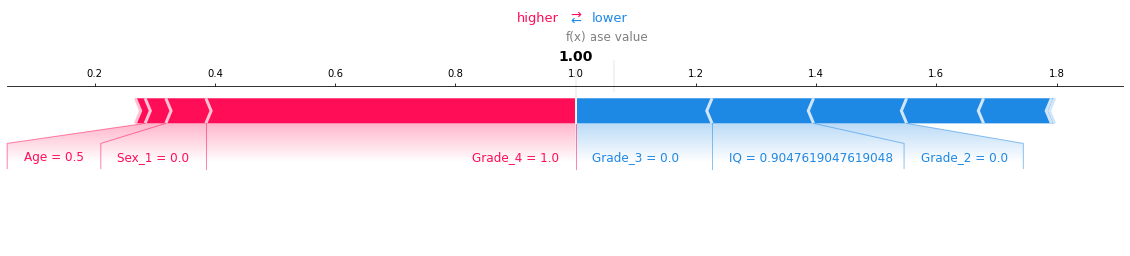

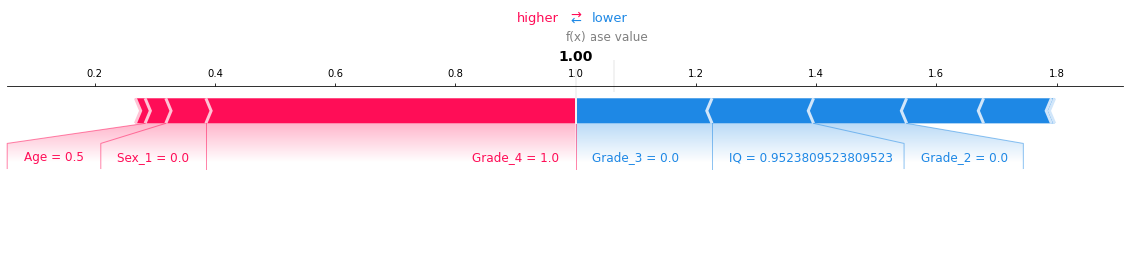

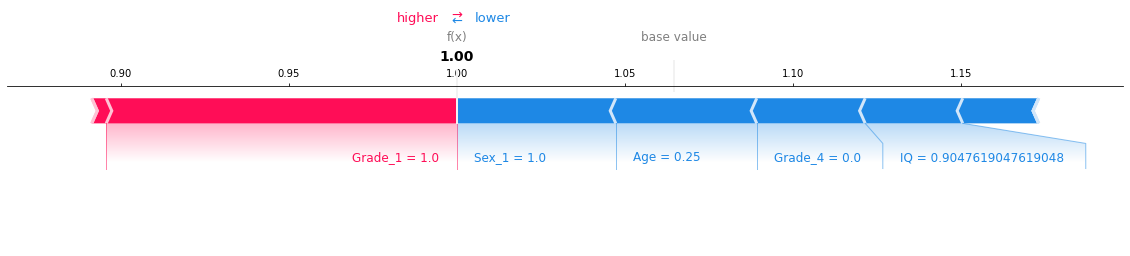

In [69]:
for d in dyslexics_rnd:
    shap.plots.force(shap_values[d], show=False, matplotlib=True)
    
    